In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize
from statsmodels.tsa.statespace import tools 
from statsmodels.tsa import stattools


from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split

from pmdarima.arima import auto_arima

import warnings


warnings.filterwarnings("ignore", category=UserWarning)
#warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
data = pd.read_excel("C:/Users/chapa/Documents/Capstone/final_data.xlsx")

In [3]:
data.head()

,Date,EPS,Book Value,COF,Dividend,inflation,Remittance Growth Rate(%),Open,High,Low,Close,Volume,MA_10,MACD,MA_30,Compound Sensitivity,Bollinger_Bandwidth
0,2018-04-27,46.7,210.0,4.63,0.48,6.0,7.0,1050.0,1050.0,1020.0,1030.0,13380,1030.1,9.680262,1004.4,0.0,103.757521
1,2018-04-28,46.7,210.0,4.63,0.48,6.0,7.0,1050.0,1050.0,1020.0,1030.0,13380,1030.1,9.680262,1004.4,0.0,103.757521
2,2018-04-29,46.7,210.0,4.63,0.48,6.0,7.0,1015.0,1020.0,1002.0,1015.0,7378,1032.6,8.143550,1004.4,0.0,123.336877
3,2018-04-30,46.7,210.0,4.63,0.48,6.0,7.0,1015.0,1020.0,1002.0,1015.0,7378,1032.6,8.143550,1004.4,0.0,123.336877
4,2018-05-01,46.7,210.0,4.63,0.48,6.0,7.0,1015.0,1020.0,1002.0,1015.0,7378,1032.6,8.143550,1004.4,0.0,123.336877


In [4]:
data.columns

Index(['Date', 'EPS', 'Book Value', 'COF', 'Dividend', 'inflation',
       'Remittance Growth Rate(%)', 'Open', 'High', 'Low', 'Close', 'Volume',
       'MA_10', 'MACD', 'MA_30', 'Compound Sensitivity',
       'Bollinger_Bandwidth'],
      dtype='object')

In [5]:
data.describe()

,EPS,Book Value,COF,Dividend,inflation,Remittance Growth Rate(%),Open,High,Low,Close,Volume,MA_10,MACD,MA_30,Compound Sensitivity,Bollinger_Bandwidth
count,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000
mean,30.829622,234.234634,6.041089,0.365295,5.711841,11.460918,920.000111,928.653621,906.706909,915.198991,52921.741301,919.672658,-3.025450,918.210968,0.682222,-113.340172
std,12.493481,27.584427,1.213535,0.053947,1.690528,13.193844,256.269678,260.501128,250.735703,254.844244,66519.167493,249.578727,22.117615,250.415164,0.518178,1491.758863
min,7.310000,184.280000,4.290000,0.300000,2.700000,-18.100000,574.300000,587.000000,574.300000,580.000000,193.000000,585.460000,-104.305686,587.300000,-0.999700,-25991.341743
25%,24.390000,210.000000,4.990000,0.340000,4.200000,-0.300000,745.000000,750.000000,734.500000,740.000000,9441.000000,759.800000,-13.142326,750.900000,0.361200,-125.909357
50%,29.200000,233.280000,6.020000,0.350000,5.970000,10.900000,846.000000,855.000000,836.000000,844.000000,36824.000000,842.900000,-4.208260,840.270000,0.987500,-37.380792
75%,35.550000,258.240000,6.840000,0.380000,7.260000,22.850000,1010.050000,1019.900000,1000.000000,1006.950000,67078.500000,1030.200000,5.807580,1004.400000,0.998200,48.951089
max,54.500000,281.410000,8.420000,0.480000,8.640000,37.300000,1660.000000,1740.000000,1640.100000,1653.000000,705430.000000,1597.770000,103.858478,1582.690000,1.000000,20081.807600


In [6]:
font = {'size' : 12}
plt.rc('font', **font)

def plot_series(X, 
                title='Time Series Plot', y_label='X', figsize=(16, 5)):
    """ Plots the time series data X.

    Args:
        X (np.array): Time-series data
        title (str): Title for the figure
        y_label (str): y-label for t he figure 
        figsize (tuple): Size of figure
    """
    
    fig = plt.figure(figsize=figsize)
    if type(X) == np.ndarray:
        plt.plot(X, linewidth=3)
        plt.xticks(range(0, len(X), 12))
    else:
        X.plot(linewidth=3)

    plt.title(title, fontsize=17)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    plt.legend([y_label])
    plt.grid()

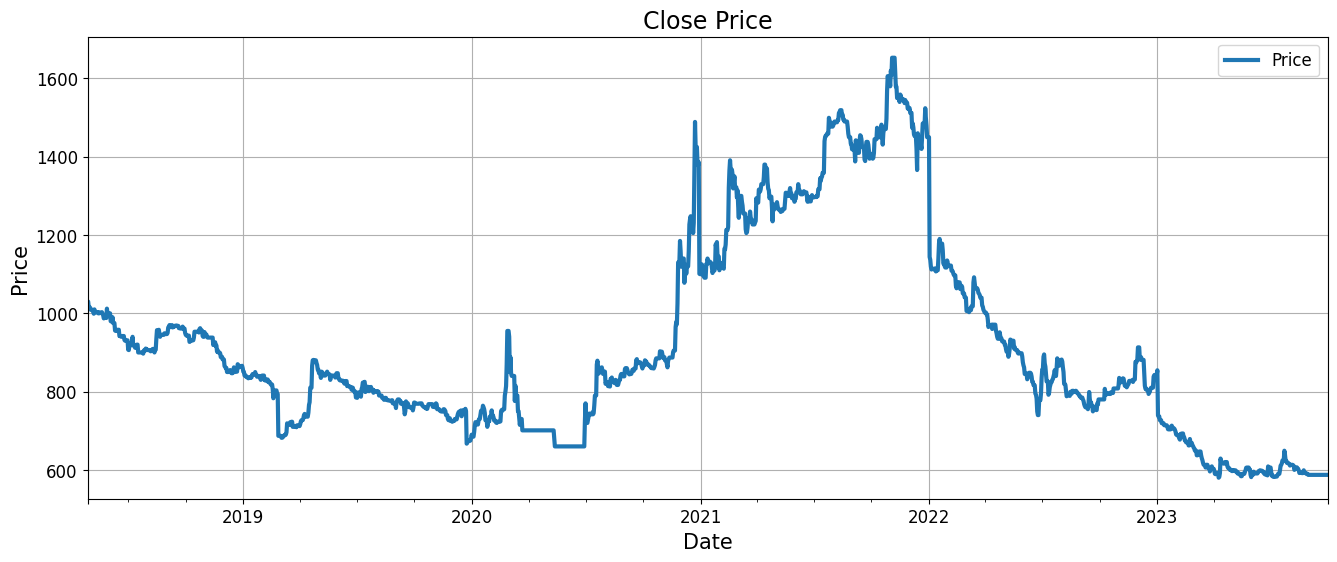

In [7]:
data.set_index(data.Date, inplace=True)

plot_series(
    data['Close'], 
    title='Close Price',
    y_label='Price',
    figsize=(16, 6))

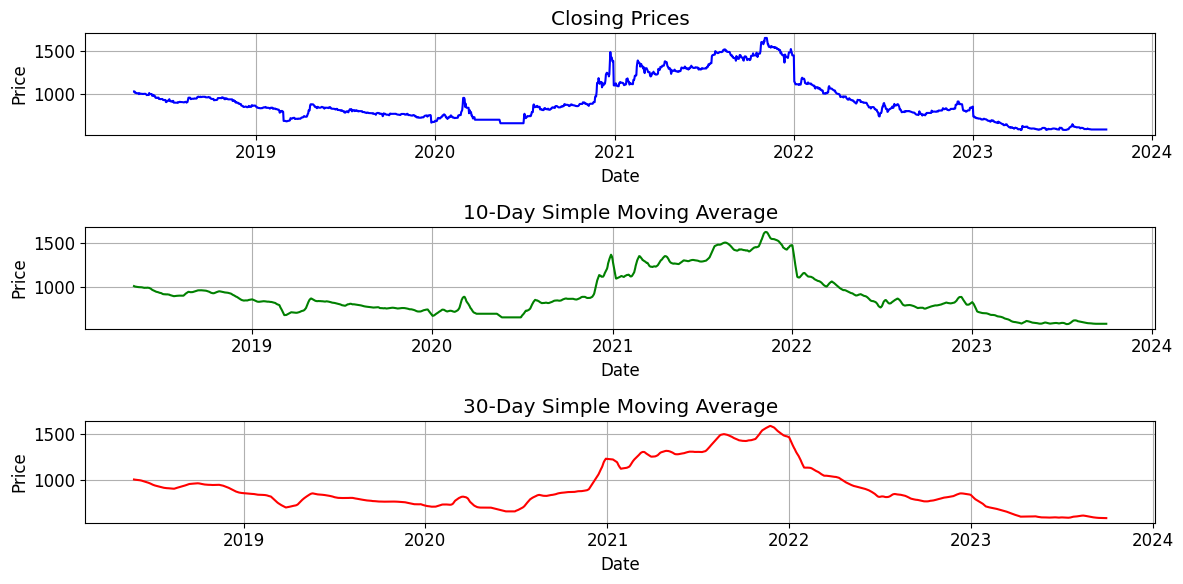

In [8]:
data['10-Day SMA'] = data['Close'].rolling(window=10).mean()
data['30-Day SMA'] = data['Close'].rolling(window=30).mean()

# Create separate plots for closing prices, 10-day SMA, and 30-day SMA
plt.figure(figsize=(12, 6))

# Plot 1: Closing Prices
plt.subplot(3, 1, 1)
plt.plot(data.index, data['Close'], label='Closing Prices', color='blue')
plt.title('Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

# Plot 2: 10-Day SMA
plt.subplot(3, 1, 2)
plt.plot(data.index, data['10-Day SMA'], label='10-Day SMA', color='green')
plt.title('10-Day Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

# Plot 3: 30-Day SMA
plt.subplot(3, 1, 3)
plt.plot(data.index, data['30-Day SMA'], label='30-Day SMA', color='red')
plt.title('30-Day Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

plt.tight_layout()
plt.show()

In [47]:
#log transformation for making variance of data constant
data['logClose'] = np.log(data['Close'].values)

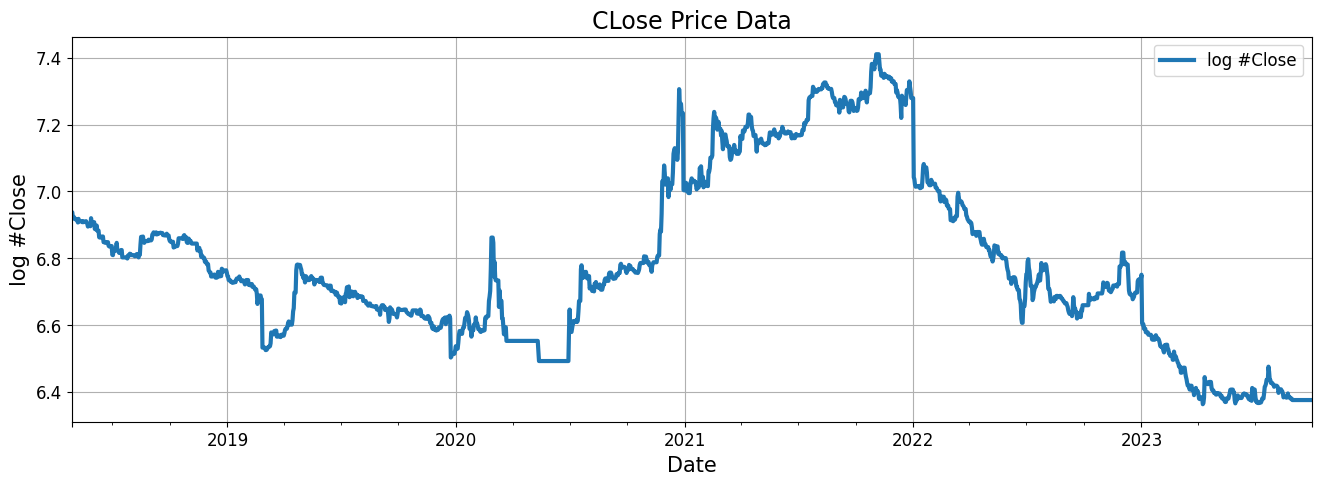

In [48]:
plot_series(
    data['logClose'], 
    title='CLose Price Data',
    y_label='log #Close',
)

In [49]:
data['logClose'].var()

0.06755043960789536

In [50]:
data['Close'].var()

64945.58860644948

[]

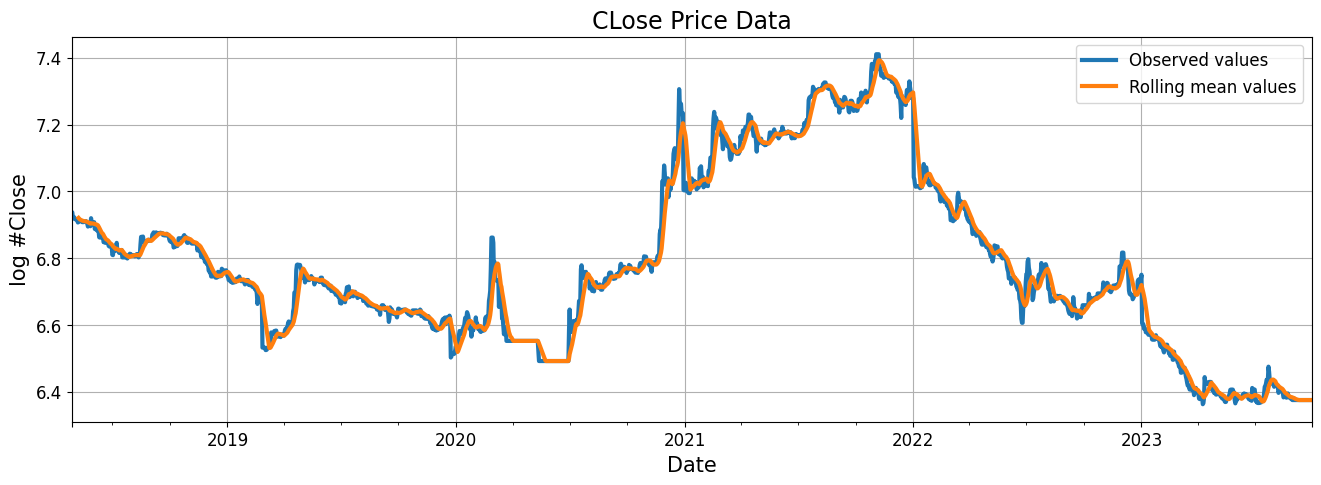

In [51]:
#rolling mean to analyze the trend present in the data
plot_series(
    data['logClose'], 
    title='CLose Price Data',
    y_label='log #Close',
)
data['logClose'].rolling(12).mean().plot(linewidth=3)
plt.legend(['Observed values', 'Rolling mean values'])
plt.grid()
plt.xlabel('Date')
plt.plot()

In [52]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data.Close.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -1.320688670192634
p-value: 0.6196548781851703


#p value greater than 0.05 ,the usual critical value so the data is non stationary 

In [53]:
from pmdarima.arima.utils import ndiffs
ndiffs(data.Close,test ='adf')

1

Value of d=1 , makes data stationary 

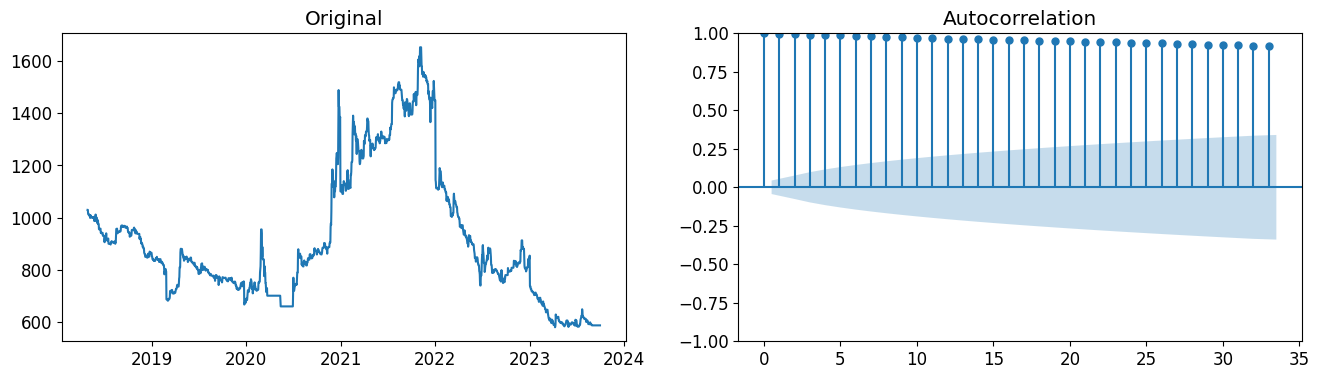

In [54]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig, (ax1,ax2)= plt.subplots(1,2,figsize=(16,4))
ax1.plot(data.Close)
ax1.set_title("Original")
plot_acf(data.Close,ax=ax2);

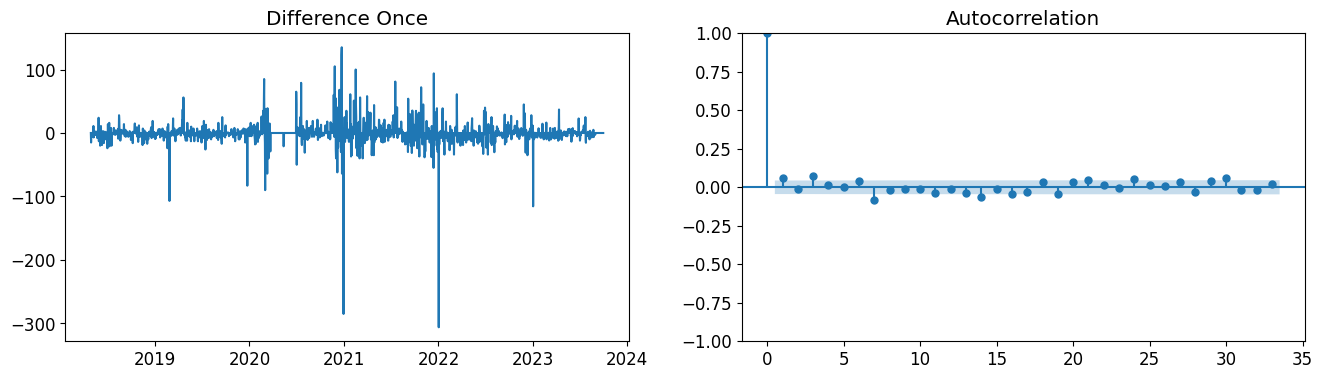

In [55]:
diff = data.Close.diff().dropna()

fig ,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference Once")
plot_acf(diff,ax=ax2);

C:\Users\chapa\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


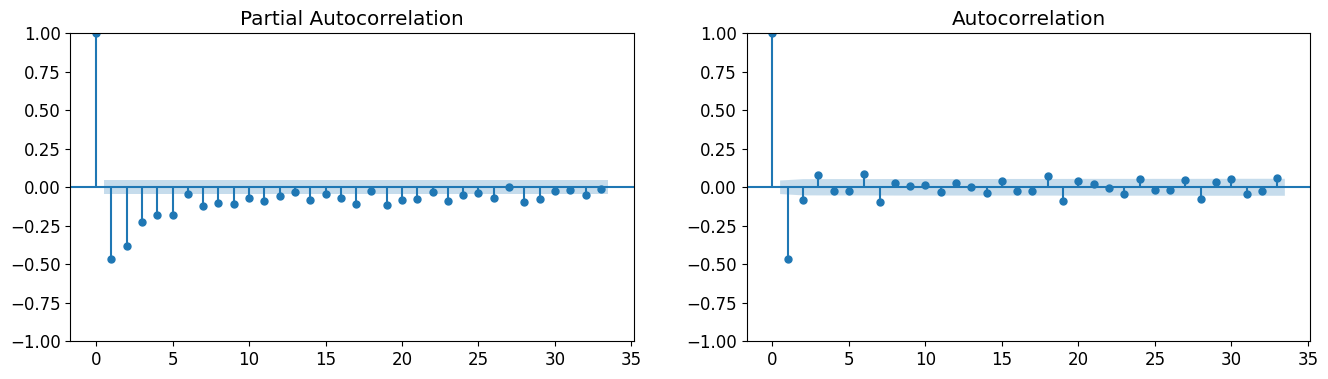

In [56]:
diff = data.Close.diff().diff().dropna()

fig ,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
plot_pacf(diff,ax=ax1);
plot_acf(diff,ax=ax2);

AR(p) from the PACF plot, MA(q) from the ACF plot

In [57]:
p_ = 5
q_ = 7
d = 2


In [ ]:
min_order

In [58]:
target_column = 'Close'

data = data[["Date", target_column]]
#data['logClose'] = np.log(data['Close'].values)


In [59]:
train_size = int(len(data) * 0.8)  # Adjust the split ratio as needed
train, test = data[:train_size], data[train_size:]


In [60]:
p=5
d=2
q=7
model = ARIMA(train[target_column], order=(p, d, q))
model_fit = model.fit()

In [61]:
n_periods = len(test)  # Forecast the entire test set
forecast = model_fit.forecast(steps=n_periods)


In [62]:
rmse = sqrt(mean_squared_error(test[target_column], forecast))
print("RMSE:", rmse)

RMSE: 85.24166960441941


In [63]:
print("Actual:", test[target_column])
print("Predicted:", forecast)

Actual: Date
2022-08-30    789.5
2022-08-31    786.0
2022-09-01    784.0
2022-09-02    784.9
2022-09-03    784.9
              ...  
2023-09-26    587.3
2023-09-27    587.3
2023-09-28    587.3
2023-09-29    587.3
2023-09-30    587.3
Name: Close, Length: 397, dtype: float64
Predicted: 2022-08-30    789.990668
2022-08-31    788.900677
2022-09-01    788.516914
2022-09-02    789.004422
2022-09-03    788.393873
                 ...    
2023-09-26    672.702451
2023-09-27    672.403476
2023-09-28    672.103812
2023-09-29    671.805761
2023-09-30    671.509427
Freq: D, Name: predicted_mean, Length: 397, dtype: float64


In [65]:
target_column = "Close"

# Apply the logarithmic transformation to the "Close" column
data['logClose'] = np.log(data[target_column])


train_size = int(len(data) * 0.8)  
train, test = data[:train_size], data[train_size:]


p = 5
d = 2
q = 7


model = ARIMA(train['logClose'], order=(p, d, q))
model_fit = model.fit()


n_periods = len(test)  
forecast = model_fit.forecast(steps=n_periods)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['logClose'], forecast))
print("RMSE:", rmse)

# Print actual and predicted values for the test set (in log scale)
print("Actual (logClose):", test['logClose'])
print("Predicted (logClose):", forecast)

RMSE: 0.15477192532679443
Actual (logClose): Date
2022-08-30    6.671400
2022-08-31    6.666957
2022-09-01    6.664409
2022-09-02    6.665556
2022-09-03    6.665556
                ...   
2023-09-26    6.375536
2023-09-27    6.375536
2023-09-28    6.375536
2023-09-29    6.375536
2023-09-30    6.375536
Name: logClose, Length: 397, dtype: float64
Predicted (logClose): 2022-08-30    6.670076
2022-08-31    6.668626
2022-09-01    6.667481
2022-09-02    6.666007
2022-09-03    6.664271
                ...   
2023-09-26    6.098843
2023-09-27    6.097385
2023-09-28    6.095928
2023-09-29    6.094470
2023-09-30    6.093013
Freq: D, Name: predicted_mean, Length: 397, dtype: float64


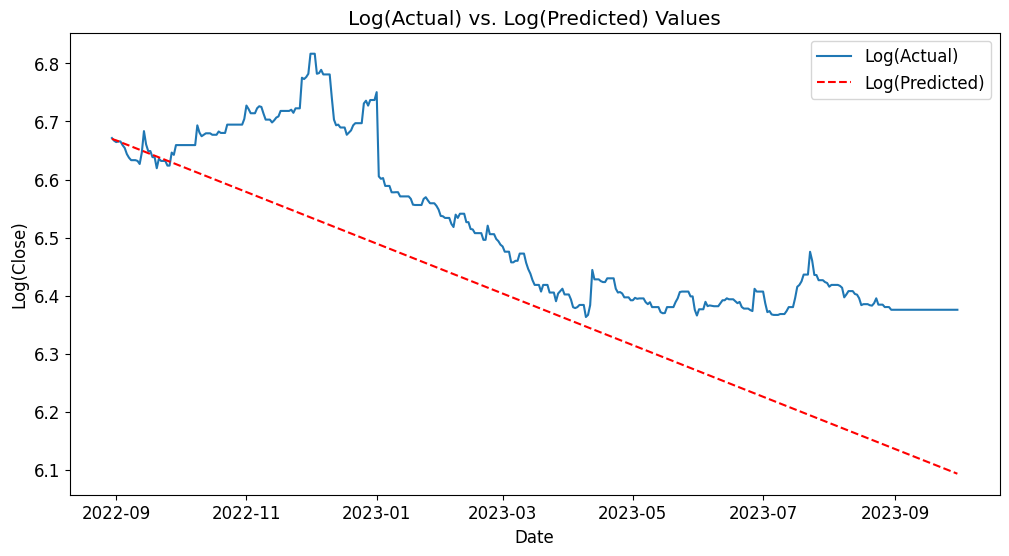

In [66]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['logClose'], label="Log(Actual)")
plt.plot(test.index, forecast, label="Log(Predicted)", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Log(Close)")
plt.legend()
plt.title("Log(Actual) vs. Log(Predicted) Values")
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13646.873, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13643.097, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13642.874, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13644.986, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13642.371, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13644.317, Time=0.92 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13644.331, Time=0.72 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=13644.165, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13644.711, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13644.809, Time=1.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=13640.475, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=13640.975, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=13641.198, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=13642.421, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0

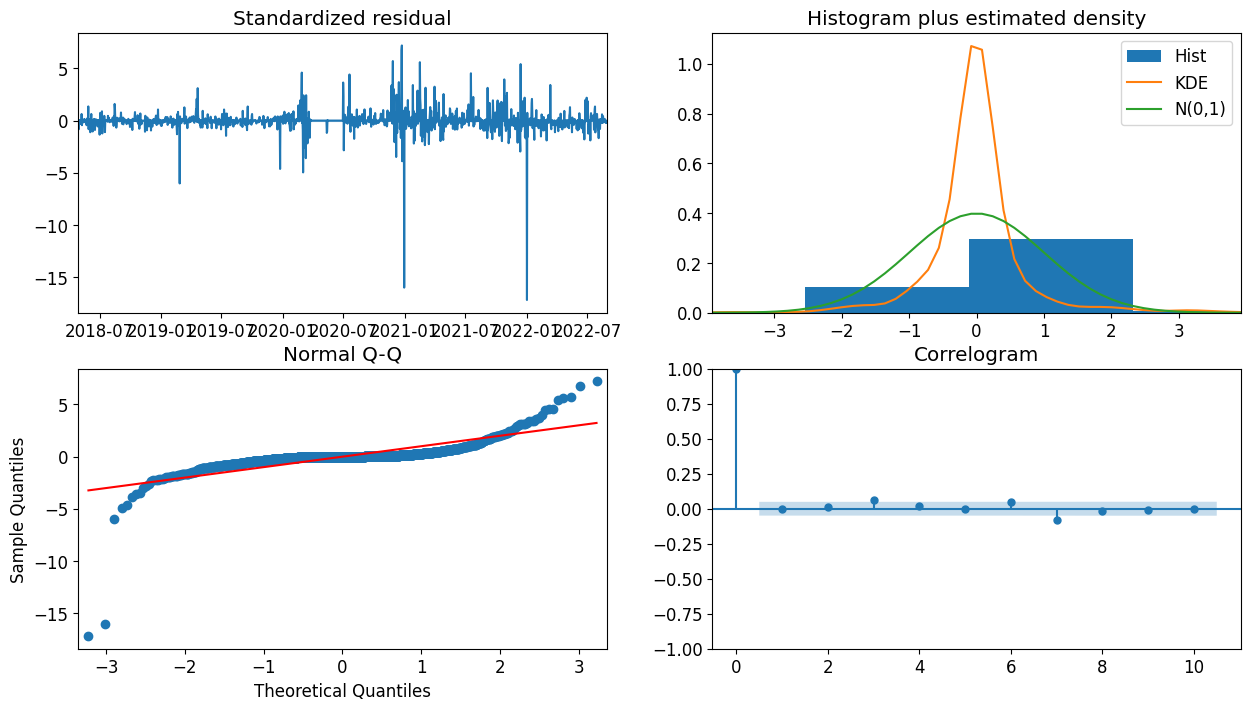

In [68]:
model_autoARIMA = auto_arima(train[target_column], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()